<a href="https://colab.research.google.com/github/setyo-dwi-pratama/FGA-DTS-KOMINFO/blob/main/09_regression_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating Multiple Models in a Python 3 Notebook

##  Introduction

The purpose of this example is to compare the performance of machine learning models within a Jupyter notebook. We will use the classic 1974 *Motor Trend* car road tests (`mtcars`) dataset to fit and evaluate three models:
1. A linear model using all variables
1. A linear model after variable selection
1. A Gradient Boosting Machine (GBM) model 

This is a lightly-modified version of a [notebook](https://gallery.cortanaintelligence.com/Notebook/Evaluating-Multiple-Models-6) originally created by a Microsoft employee for distribution on the [Cortana Intelligence Gallery](https://gallery.cortanaintelligence.com/). [Python 2 and R versions](https://notebooks.azure.com/library/eSJDgAFMXAY) of this notebook are also available on Azure Notebooks.

## Outline

- [Introduction](#Introduction)
- [Prepare Data](#Prepare-Data)
- [Fit Models](#Fit-Models)
   - [Linear Model](#Linear-Model)
   - [Linear Model with Feature Selection](#Linear-Model-with-Feature-Selection)
   - [Gradient Boosting Machine Regression Model](#Gradient-Boosting-Machine-Regression-Model)
- [Conclusion](#Conclusion)

Ref : https://notebooks.azure.com/Microsoft/projects/ComparingModels/html/Evaluating%20Multiple%20Models%20in%20a%20Python%203%20Notebook.ipynb

## Prepare Data

We'll start by loading the `mtcars` sample dataset and displaying its description:

In [4]:
#!pip install pydataset --disable-pip-version-check -q 
!pip install pydataset
import pydataset 
from pydataset import data
df = data('mtcars')
data('mtcars', show_doc=True)

     |████████████████████████████████| 15.9MB 206kB/s 
  Created wheel for pydataset: filename=pydataset-0.2.0-cp36-none-any.whl size=15939431 sha256=5f38dd6095948ce76671c7858d85c56bba4569e323d3edfac24b3b2dde9a43d9
  Stored in directory: /root/.cache/pip/wheels/fe/3f/dc/5d02ccc767317191b12d042dd920fcf3432fab74bc7978598b
Successfully built pydataset
initiated datasets repo at: /root/.pydataset/
mtcars

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Motor Trend Car Road Tests

### Description

The data was extracted from the 1974 _Motor Trend_ US magazine, and comprises
fuel consumption and 10 aspects of automobile design and performance for 32
automobiles (1973–74 models).

### Usage

    mtcars

### Format

A data frame with 32 observations on 11 variables.

[, 1]

mpg

Miles/(US) gallon

[, 2]

cyl

Number of cylinders

[, 3]

disp

Displacement (cu.in.)

[, 4]

hp

Gross horsepower

[, 5]

drat

Rear axle ratio

[, 6]

wt

Weight (lb/1000

We can also quickly examine the distribution of values and first few rows of the dataset:

In [5]:
df.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [6]:
df.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp      32 non-null     int64  
 4   drat    32 non-null     float64
 5   wt      32 non-null     float64
 6   qsec    32 non-null     float64
 7   vs      32 non-null     int64  
 8   am      32 non-null     int64  
 9   gear    32 non-null     int64  
 10  carb    32 non-null     int64  
dtypes: float64(5), int64(6)
memory usage: 4.2+ KB


The goal for the machine learning models in this tutorial will be to predict each car's gas mileage (`mpg`) from the car's other features.

We will split the records into training and test datasets: each model will be fitted using the training data, and evaluated using the withheld test data.

In [ ]:
from sklearn.model_selection import train_test_split

# split the dataset into features available for prediction (X) and value to predict (y)
y = df['mpg'].values
X = df.drop('mpg', 1).values
feature_names = df.drop('mpg', 1).columns

# save 30% of the records for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=123)
X_train.shape

(9, 10)

As you can see from the description above, the number of predictive features available in this dataset (10) is comparable to the number of records (22). Such conditions tend to produce overfitted models that give exceptional predictions on their own training data, but poor predictions on the withheld test data. We will see an example of an overfitted model below.

## Fit Models
### Linear Model
The following lines of code fit a linear model (without regularization) using all of the original features:

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Below, we print the R-squared value for the true vs. predicted `mpg` values in the *training* set. We also show the fitted coefficients for different features.

In [ ]:
import pandas as pd
from sklearn.metrics import r2_score

# print R^2 for the training set
print('The R-squared value for the training set is: {:0.4f}'.format(r2_score(y_train, lm.predict(X_train))))

# print intercept and coefficients
param_df = pd.DataFrame({"Coefficient": [lm.intercept_] + list(lm.coef_),
                         "Feature": ['intercept'] + list(feature_names)})
param_df[['Feature', 'Coefficient']]

The R-squared value for the training set is: 1.0000


,Feature,Coefficient
0,intercept,-96.037501
1,cyl,-5.777114
2,disp,0.183642
3,hp,-0.245128
4,drat,20.683140
5,wt,6.713631
6,qsec,5.128808
7,vs,-12.882279
8,am,34.980730
9,gear,-19.251219


Notice that the model performs very well on the training data to which it was fitted. (Predictions of the model account for 89% of the variance in `mpg` values.) Some of the feature coefficients may reflect our intuition: for example, heavy cars tend to have worse gas mileage ($\beta_{\textrm{wt}} = -5.0$), and cars with manual transmissions tend to have better gas mileage ($\beta_{\textrm{am}} = 5.2$).

Now, let's check the model's performance on the test dataset:

In [ ]:
import numpy as np

predicted = lm.predict(X_test)

r_squared = r2_score(y_test, predicted)
mae = np.mean(abs(predicted - y_test))
rmse = np.sqrt(np.mean((predicted - y_test)**2))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)

# Create a data frame for storing results from each model
summary_df = pd.DataFrame(index = ['R-squared', 'Mean Absolute Error', 'Root Mean Squared Error',
                                   'Relative Absolute Error', 'Relative Squared Error'])
summary_df['Linear Regression, all variables'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables"
R-squared,-15.887973
Mean Absolute Error,15.632566
Root Mean Squared Error,22.142005
Relative Absolute Error,3.630851
Relative Squared Error,16.887973


Notice that the R-squared value for true vs. predicted `mpg` of the test set is much lower than it was for the training set. (Granted, our test set is not very large, so some fluctuation is expected.) This is indicative of model overfitting.

### Linear Model with Feature Selection

One way to reduce overfitting is to remove some predictive features from the model. Ideally we would be able to examine many or all possible subsets of features and select the subset of features that gives the best performance, but that is usually impractical due to the large number of possible subsets. A common alternative is to start from the full list of features and recursively remove one that seems to be contributing least to the model's performance (i.e., the feature whose removal has the least negative/most positive effect on model performance). This process is called recursive feature elimination (RFE).

RFE fits many models and compares their performance: it therefore requires both training and testing data. We would like to reserve the test dataset we created earlier to fairly compare all models, so RFE will need to set aside some records in the `X_train`/`y_train` dataset for its own round of testing. Fortunately, this is easily done with `scikit-learn`'s cross-validation functionality:

Optimal number of features: 3
Features selected: drat, am, gear
Suggested order of feature removal: qsec, cyl, disp, vs, wt, hp, carb, drat, am, gear


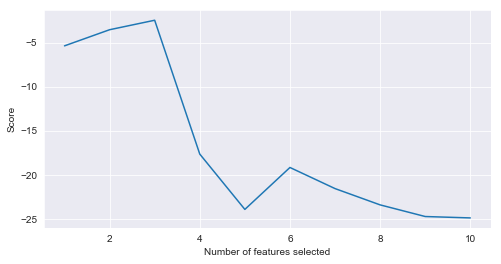

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
import seaborn as sns

# scale each feature to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# recursive feature elimination with cross validation, using r-squared score as metric
lm = LinearRegression()  # using a linear model as before
rfecv = RFECV(estimator=lm, step=1, cv=5) 
rfecv.fit(X_scaled, y_train)

# print the optimal number of features
print('Optimal number of features: {}'.format(rfecv.n_features_))

# save the selected features
print('Features selected: {}'.format(', '.join(np.array(feature_names)[rfecv.support_].tolist())))

# get the feature elimination order
ranked_features, _ = zip(*sorted(zip(feature_names, rfecv.ranking_.tolist()),
                                 key=lambda x: x[1],
                                 reverse=True))
print('Suggested order of feature removal: {}'.format(', '.join(ranked_features)))

# plot number of features vs. scores
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

The plot shows that the performance of the model (on the cross-validation testing set) tends to improve as we reduce the number of features in the model. As expected, weight and presence of an automatic transmission are among the features which would be removed last (since they are relevant for predicting gas mileage), whereas the number of forward gears is not so relevant.

We can now fit a linear model using only the selected features, and assess its performance on the test set:

In [ ]:
X_train_subset = X_train[:, rfecv.support_]
lm2 = LinearRegression()
lm2.fit(X_train_subset, y_train)

X_test_part = X_test[:, rfecv.support_]
predicted = lm2.predict(X_test_part)

r_squared = r2_score(y_test, predicted)
mae = np.mean(abs(predicted - y_test))
rmse = np.sqrt(np.mean((predicted - y_test)**2))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)

summary_df['Linear Regression, selected variables'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables","Linear Regression, selected variables"
R-squared,-15.887973,-0.225340
Mean Absolute Error,15.632566,4.943677
Root Mean Squared Error,22.142005,5.964259
Relative Absolute Error,3.630851,1.148228
Relative Squared Error,16.887973,1.225340


In [ ]:
sorted(SCORERS.keys())


NameError: name 'SCORERS' is not defined

The model's performance on the withheld test set improved (by all metrics) after the majority of features were removed.

### Gradient Boosting Machine Regression Model

Before fitting the gradient boosting model, we need to estimate some parameters and we'll do this using cross-validation along with grid search. The following code box may take some time to run:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from time import time
from sklearn.metrics import make_scorer, SCORERS

# We will try all combinations of these possible parameter values
tuned_params = {'n_estimators': [5000, 10000], 
                'max_depth': [2,4], 
                'min_samples_split': [2],
                'learning_rate': [0.001, 0.01]}
gscv = GridSearchCV(GradientBoostingRegressor(loss = 'ls', random_state=0), 
                    tuned_params, cv=5, scoring='neg_mean_absolute_error')

# th
start = time()
gscv.fit(X_train, y_train)

print('The grid cross validation lasted {:0.1f} seconds'.format(time() - start))
print('Best parameters set found on development set:\n\t{}'.format(
        ', '.join(['{}: {}'.format(i,j) for i,j in gscv.best_params_.items()])))
print('Grid scores on development set:')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The grid cross validation lasted 37.3 seconds
Best parameters set found on development set:
	learning_rate: 0.01, max_depth: 2, min_samples_split: 2, n_estimators: 5000
Grid scores on development set:


We'll fit the GBM model with the parameters that gave the best performance:

In [ ]:
# fit model with the best set of parameter values
params = gscv.best_params_
params['random_state'] = 123
params['loss'] = 'ls'
gbm = GradientBoostingRegressor(**params)

gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5000, n_iter_no_change=None, presort='auto',
             random_state=123, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Now we can check the model's performance on the test data:

In [ ]:
predicted = gbm.predict(X_test)

r_squared = r2_score(y_test, predicted)
mae = np.mean(abs(predicted - y_test))
rmse = np.sqrt(np.mean((predicted - y_test)**2))
rae = np.mean(abs(predicted - y_test)) / np.mean(abs(y_test - np.mean(y_test)))
rse = np.mean((predicted - y_test)**2) / np.mean((y_test - np.mean(y_test))**2)

summary_df['Gradient Boosted Machine Regression'] = [r_squared, mae, rmse, rae, rse]
summary_df

,"Linear Regression, all variables","Linear Regression, selected variables",Gradient Boosted Machine Regression
R-squared,-15.887973,-0.225340,0.768302
Mean Absolute Error,15.632566,4.943677,2.125982
Root Mean Squared Error,22.142005,5.964259,2.593518
Relative Absolute Error,3.630851,1.148228,0.493785
Relative Squared Error,16.887973,1.225340,0.231698


The plot below shows the feature importances:

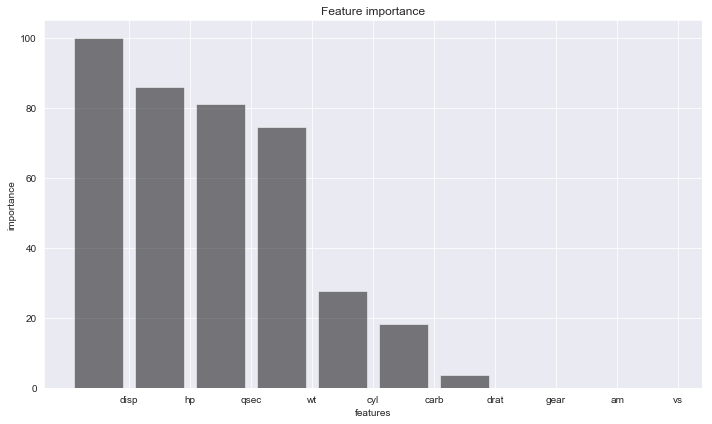

In [ ]:
# plot variable importance
import numpy as np
import matplotlib.pyplot as plt

feature_importance = gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
index = np.arange(len(feature_names))
bar_width = 0.5
plt.bar(index, feature_importance[sorted_idx], color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index + bar_width, np.array(feature_names)[sorted_idx])
plt.tight_layout()
plt.show()

Some features which were eliminated later by RFE (like `am`) have low feature importance in the GBM model.

Let's assess whether our GBM model's performance is likely to be limited by the number of estimators used:

Text(0, 0.5, 'Deviance')

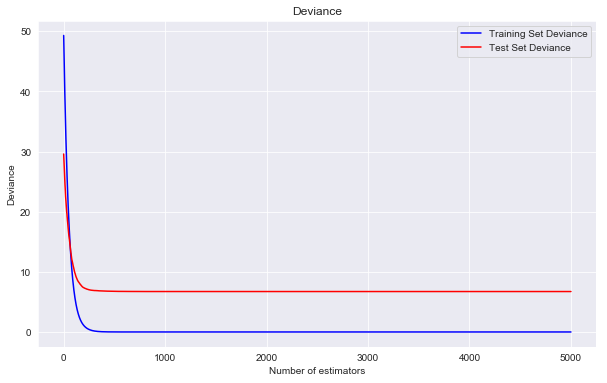

In [ ]:
# plot deviance for training set and test set
test_score = np.zeros(params['n_estimators'])

for j, y_pred in enumerate(gbm.staged_predict(X_test)):
    test_score[j] = gbm.loss_(y_test, y_pred)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Number of estimators')
plt.ylabel('Deviance')

The plot above demonstrates that the loss function plateaus well before we reach the total number of estimators used by our model. We could likely get away with using fewer estimators for a speed improvement.

## Conclusion
The following table compares the performance of the three models. Variable selection using RFE improved the performance of the linear regression model by all metrics. The GBM model performed comparably to linear regression with variable selection. (We will avoid reading too deeply into the differences in metrics, because the test dataset is so small.)

In [ ]:
summary_df